In [23]:
'''
Start with array of cells for each row
======================================
First row will be ignored => [Code | Student Name | English Name | 1 | 2 | 3]

For each row:
1- Check for user choosed method (OCR or features + classifier)
2- For the first 3 cells [Code | Student Name | English Name ] 
    apply the method to it and push the result to output array
3- For the next 3 cells apply the following
	a) Check if it is ✓
	b) Else, check if it is (box)
	c) Else, check if it is -  ===> check if the width of minus is less than half the cell width
	d) Else, check if it is ?  ===> output will be empty cell with red background
	e) Else, check if is a stacked vertical lines  ===> output will be number of this lines
	f) Else, check if it a stacked horizontal lines  ===> output will be number of this lines
	g) If all the previous didn't give an output, then use the method to detect numeric values
4- Final output should be an array with the following
	[Code, Arabic Name, English Name, First cell output, Second cell output, Third cell output]

'''

"\nStart with array of cells for each row\n======================================\nFirst row will be ignored => [Code | Student Name | English Name | 1 | 2 | 3]\n\nFor each row:\n1- Check for user choosed method (OCR or features + classifier)\n2- For the first 3 cells [Code | Student Name | English Name ] \n    apply the method to it and push the result to output array\n3- For the next 3 cells apply the following\n\ta) Check if it is ✓\n\tb) Else, check if it is (box)\n\tc) Else, check if it is -  ===> check if the width of minus is less than half the cell width\n\td) Else, check if it is ?  ===> output will be empty cell with red background\n\te) Else, check if is a stacked vertical lines  ===> output will be number of this lines\n\tf) Else, check if it a stacked horizontal lines  ===> output will be number of this lines\n\tg) If all the previous didn't give an output, then use the method to detect numeric values\n4- Final output should be an array with the following\n\t[Code, Arabic 

In [24]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pytesseract

import os
os.environ["TESSDATA_PREFIX"] = r'C:\Users\iiBesh00\AppData\Local\Tesseract-OCR\tessdata'
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\iiBesh00\AppData\Local\Tesseract-OCR\tesseract.exe'

In [26]:
def getCodeOrName(img, ara=False):
	'''
	img: Gray level image
	ara: False for codes and english names, True for arabic name
	'''
	# get the string from the image and split it to get the wanted part
	text = ""
	if ara:
		_, threshImg = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
		text = pytesseract.image_to_string(threshImg, lang="ara")
	else:
		text = pytesseract.image_to_string(img)
	return text.split('\n')[0]

# img = cv2.imread("./Samples/Detection phase samples/code.png", cv2.IMREAD_GRAYSCALE)
# print(getCodeOrName(img))
# show_images([img])

# img = cv2.imread("./Samples/Detection phase samples/english name.png", cv2.IMREAD_GRAYSCALE)
# print(getCodeOrName(img))
# show_images([img])

# img = cv2.imread("./Samples/Detection phase samples/arabic name2.png", cv2.IMREAD_GRAYSCALE)
# print(getCodeOrName(img, True))
# show_images([img])

In [27]:
# OLD VERSION
def detectVerticalLines(img):
	dens = np.sum(img, axis=0)
	mean = np.mean(dens)

	thresh = 255 * np.ones_like(img)
	k = 0.9
	for idx, val in enumerate(dens):
		if val < k * mean:
			thresh[:,idx] = 0
	
	thresh[:, 0:20] = 255
	thresh[:, -20:] = 255
	thresh = 255 - thresh
	
	contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	return len(contours)

def detectHorizontalLines(img):
	img = img > np.mean(img)

	dens = np.sum(img, axis=1)
	mean = np.mean(dens)

	thresh = 255 * np.ones_like(img)
	k = 0.9
	for idx, val in enumerate(dens):
		if val < k * mean:
			thresh[idx,:] = 0
	thresh[0:7,:] = 255
	thresh[-5:,:] = 255
	thresh = 255 - thresh

	contours, _ = cv2.findContours(thresh, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)
	return len(contours)


# img = cv2.imread("./Samples/Detection phase samples/vertical lines.png", cv2.IMREAD_GRAYSCALE)
# num = detectVerticalLines(img) # 3
# num1 = detectHorizontalLines(img) # 0
# print(num, num1)

# img = cv2.imread("./Samples/Detection phase samples/vertical lines1.png", cv2.IMREAD_GRAYSCALE)
# num = detectVerticalLines(img) # 1
# num1 = detectHorizontalLines(img) # 0
# print(num, num1)

# img = cv2.imread("./Samples/Detection phase samples/horizontal lines.png", cv2.IMREAD_GRAYSCALE)
# num = detectVerticalLines(img) # 0
# num1 = detectHorizontalLines(img) # 2
# print(num, num1)

# img = cv2.imread("./Samples/Detection phase samples/horizontal lines1.png", cv2.IMREAD_GRAYSCALE)
# num = detectVerticalLines(img) # 0
# num1 = detectHorizontalLines(img) # 4
# print(num, num1)

# # detect box
# img = cv2.imread("./Samples/Detection phase samples/box.png", cv2.IMREAD_GRAYSCALE)
# num = detectVerticalLines(img)
# num1 = detectHorizontalLines(img)
# print(num, num1)


In [56]:
def detechRightMark(img):
	'''
	img: Gray level image given to detect if it was right mark => True
	'''
	img = cv2.GaussianBlur(img, (5,5), 0)
	_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	img_bin = 255 - img_bin
	img_bin[0:10,:] = 0
	img_bin[-10:,:] = 0
	img_bin[:, 0:20] = 0
	img_bin[:, -20:] = 0

	erodeKernel = np.ones((3,3),np.uint8)
	erosion = cv2.erode(img_bin, erodeKernel, iterations=1)

	kernel = np.array([
		[0,0,0,0,0,0,1],
		[0,0,0,0,0,1,0],
		[0,0,0,0,1,0,0],
		[0,0,0,1,0,0,0],
		[0,0,1,0,0,0,0],
		[0,1,0,0,0,0,0],
		[1,0,0,0,0,0,0]
	], dtype=np.uint8)

	diagonal = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations=1)
	diagonalContours, _ = cv2.findContours(diagonal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	diagonalResult = len(diagonalContours)

	verticalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
	vertical = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, verticalKernel, iterations=1)
	verticalContours, _ = cv2.findContours(vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	verticalResult = len(verticalContours)

	return (verticalResult == 1 and diagonalResult == 1)

img = cv2.imread("./Samples/Detection phase samples/right.png", cv2.IMREAD_GRAYSCALE)
print(detechRightMark(img))

True


In [47]:
def detectVerticalLines(img):
	'''
	img: Gray level image given to detect if it was vertical line => number of lines
	'''
	img = cv2.GaussianBlur(img, (5,5), 0)
	_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	img_bin = 255 - img_bin
	img_bin[0:10,:] = 0
	img_bin[-10:,:] = 0
	img_bin[:, 0:20] = 0
	img_bin[:, -20:] = 0

	verticalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
	vertical = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, verticalKernel, iterations=1)
	verticalContours, _ = cv2.findContours(vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	
	return len(verticalContours)

def detectHorizontalLines(img):
	'''
	img: Gray level image given to detect if it was horizontal line => number of lines
	'''
	img = cv2.GaussianBlur(img, (5,5), 0)
	_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	img_bin = 255 - img_bin
	img_bin[0:10,:] = 0
	img_bin[-10:,:] = 0
	img_bin[:, 0:20] = 0
	img_bin[:, -20:] = 0

	horizontalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
	horizontal = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontalKernel, iterations=1)

	horizontalContours, _ = cv2.findContours(horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	
	return len(horizontalContours)

def detectBoxs(img):
	'''
	img: Gray level image given to detect if it was box => True
	'''
	verticals = detectVerticalLines(img)
	horizontals = detectHorizontalLines(img)

	return (verticals == 2 and horizontals == 2)

# img = cv2.imread("./Samples/Detection phase samples/vertical lines.png", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("./Samples/Detection phase samples/horizontal lines1.png", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("./Samples/Detection phase samples/box1.png", cv2.IMREAD_GRAYSCALE)
print(detectVerticalLines(img))
print(detectHorizontalLines(img))
print(detectBoxs(img))

0
4
False


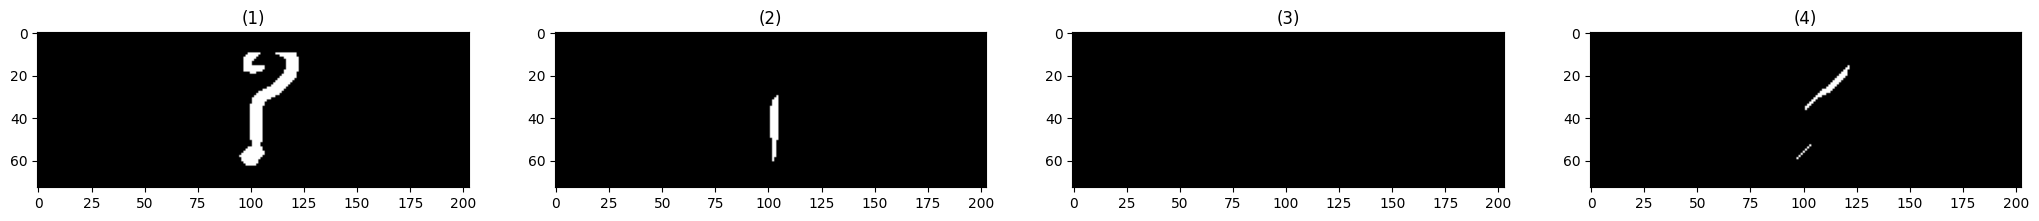

In [30]:
img = cv2.imread("./Samples/Detection phase samples/question mark.png", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("./Samples/Detection phase samples/vertical lines1.png", cv2.IMREAD_GRAYSCALE)

img = cv2.GaussianBlur(img, (5,5), 0)
_, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin = 255 - img_bin
img_bin[0:10,:] = 0
img_bin[-10:,:] = 0
img_bin[:, 0:20] = 0
img_bin[:, -20:] = 0

erodeKernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(img_bin, erodeKernel, iterations=1)

verticalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
vertical = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, verticalKernel, iterations=1)

horizontalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
horizontal = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, horizontalKernel, iterations=1)

kernel = np.array([
	[0,0,0,0,0,0,1],
	[0,0,0,0,0,1,0],
	[0,0,0,0,1,0,0],
	[0,0,0,1,0,0,0],
	[0,0,1,0,0,0,0],
	[0,1,0,0,0,0,0],
	[1,0,0,0,0,0,0]
], dtype=np.uint8)
diagonal = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations=1)
diagonalContours, _ = cv2.findContours(diagonal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

show_images([img_bin, vertical, horizontal, diagonal])